In [3]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
stage_path = "/Users/cezar/Desktop/Team Project/AI/shotput/stage1/videos"

In [4]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to calculate angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)  # First point
    b = np.array(b)  # Second point (vertex)
    c = np.array(c)  # Third point
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Process videos in the stage path
for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for left leg
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
                left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                              landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]

                # Calculate angle for left leg
                angle_left_leg = calculate_angle(left_hip, left_knee, left_ankle)

                # Store data for this frame
                keypoints_data.append({
                    "frame": cap.get(cv2.CAP_PROP_POS_FRAMES),
                    "left_leg_angle": angle_left_leg,
                    "left_hip": left_hip,
                    "left_knee": left_knee,
                    "left_ankle": left_ankle
                })

        # Release the video
        cap.release()

        # Save keypoints to a JSON file
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(stage_path, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Keypoints extraction complete!")


I0000 00:00:1736958995.707093 13498970 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Pro
W0000 00:00:1736958995.832730 13499686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736958995.846461 13499695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736958995.863603 13499693 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Keypoints extraction complete!


In [5]:
sequences = []
labels = []

for file in os.listdir(stage_path):
    if file.endswith("_keypoints.json"):
        with open(os.path.join(stage_path, file), "r") as f:
            data = json.load(f)

        # Extract angles across all frames
        angles = [frame["left_leg_angle"] for frame in data]
        sequences.append(angles)

        # Extract label from the filename
        label = float(file.split("_")[0])  # Assumes score is in the filename
        labels.append(label)

# Pad sequences to the same length
max_len = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
labels = np.array(labels)

print(f"Loaded {len(sequences)} sequences with labels.")

Loaded 17 sequences with labels.


In [6]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 85


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Reshape for LSTM input
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 65, Validation samples: 20


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())

/Users/cezar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0922 - mae: 0.1738 - val_loss: 0.1477 - val_mae: 0.2253
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0841 - mae: 0.1707 - val_loss: 0.1459 - val_mae: 0.2263
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0775 - mae: 0.1616 - val_loss: 0.1454 - val_mae: 0.2275
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0714 - mae: 0.1565 - val_loss: 0.1471 - val_mae: 0.2245
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0641 - mae: 0.1468 - val_loss: 0.1494 - val_mae: 0.2205
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0724 - mae: 0.1457 - val_loss: 0.1507 - val_mae: 0.2186
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0960 - mae: 0.1679 - val_loss: 0.1491 - val_mae: 0.2214
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0905 - mae: 0.1627 - val_loss: 0.1485 - val_mae: 0.2224
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0846 - mae: 

In [26]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.1026, Validation MAE: 0.1828


In [28]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted: 0.99, Actual: 1.00
Predicted: 0.61, Actual: 0.00
Predicted: 1.02, Actual: 1.00
Predicted: 0.98, Actual: 0.00
Predicted: 0.92, Actual: 1.00
Predicted: 0.92, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 0.93, Actual: 1.00
Predicted: 0.61, Actual: 0.00
Predicted: 0.98, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 0.84, Actual: 1.00
Predicted: 0.62, Actual: 1.00
Predicted: 0.95, Actual: 1.00
Predicted: 1.01, Actual: 1.00
Predicted: 0.95, Actual: 1.00
Predicted: 0.65, Actual: 1.00
Predicted: 1.07, Actual: 1.00
Predicted: 0.93, Actual: 1.00
Predicted: 1.00, Actual: 1.00


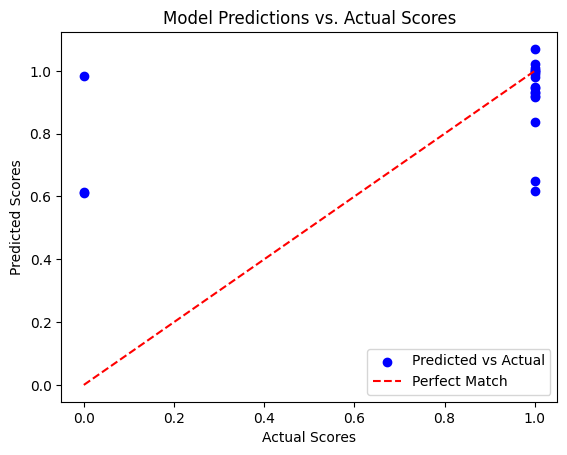

In [29]:
# Scatter plot of predictions vs. actual
plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [38]:
new_video_path = "/Users/cezar/Desktop/Team Project/AI/shotput_models/stage1/0_user12.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
        new_keypoints.append(calculate_angle(left_hip, left_knee, left_ankle))

cap.release()

# Pad the sequence
new_keypoints = pad_sequences([new_keypoints], maxlen=X_train.shape[1], padding='post', dtype='float32')
new_keypoints = new_keypoints[..., np.newaxis]  # Add channel dimension

# Predict score for the new video
predicted_score = model.predict(new_keypoints)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Score: 0.64


In [9]:
print(X_train.shape[1])

169


In [39]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.85:
        return 1.0
    elif prediction >= 0.70:
        return 0.5
    else:
        return 0.0

In [40]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.5, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0


In [41]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [42]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [43]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Classification Accuracy: 0.80


In [44]:
model.save("shotput_stage1.keras")